# Pixxel: Hyperspectral Image Analysis

In [1]:
from IPython.display import HTML, display
import warnings
warnings.filterwarnings('ignore')

This assignment covers different aspects of analysis of hyperspectral images taken from satellites. In our case, **EO1 - Earth Observing 1**

Unlike normal images that are mostly are RGB in nature, ie only represent the image in Red, Blue & Green layers, hyperspectral images take from EO1 can have upto 242 such layers, RGB being a part of the 242 layers. In scientific terms, these layers are termed as **bands**. Such are the two image tiles in our analysis, where each of the tiles have 242 bands

The difference between each *band* being the different **wavelength** of them while it was being captured

**Basic Terminology**

Before we begin with our analysis, some basic walk-though of different terms will help us understand the analysis further down easily. 

Multi and Hyper spectral images are two different things. A MS image can have upto 10 bands while a HS can have upto thousands of bands.

##### Multi-Spectral Image with 5 bands and 3 bands in visible spectrum (RGB)
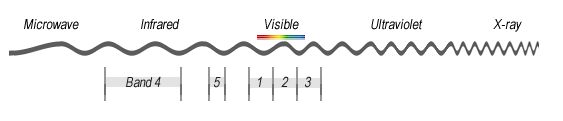

##### Hyperspectral image show multiple bands, multiple bands within visible spectrum show how narrow the wavelengths are
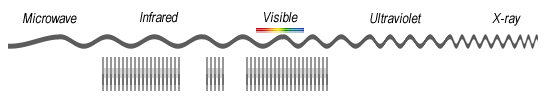

The key point here is that humans can infer only the RGB spectrum band that have a *wavelength of 380 - 700 nanometers*. Now, this brings us to another important term ie **wavelengths**

Different bands depict different wavelengths and this is what makes it easier for us to infer different insights by viewing different bands of the same image. Because we're segmenting at such narrow scales, we can observe the most minute changes in these images, be it in terms of water, vegetation, sand or clouds. 

The following table helps us understand what different bands can help us infer

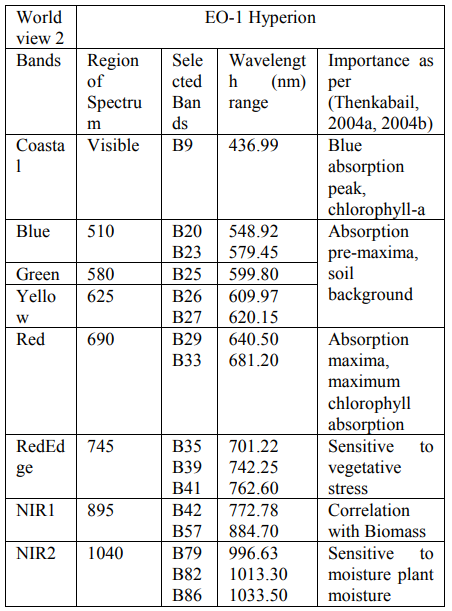

To conclude, here's a list of most common bands we'll talk about in our analysis

- Red Band = **Band 33**
- Green Band = **Band 25**
- Blue Band = **Band 23**
- NIR (Near Infra Red) Band = **Band 50**

This band-color relation is specific to EO1 only

### PROBLEM STATEMENT

Given are a pair of image tiles captured from EO1 satellite, we'd want to classify the different areas of image in terms of land, water or anything else in an unsupervised manner

#### Approach

- Know the data
- Visualize it
- Wavelet Analysis
- Pre-Process -> Clean/Normalize
- Feature Extraction/Reduction
- Band-Level Clustering
- Pixel-Level Clustering

### UNDERSTANDING OUR DATA

Now that we know what we're trying to achive, let's begin with having a basic sense of what our data is about

Given are two sets of image folder:
- EO1H1430452010208110Kt
- EO1H1480472016328110PZ

Each of them have 242 TIF images and a metadata file. The 242 images represent the 242 bands of a single image

Using the meta files, we can read the 4 corner Lat/Long points and have a glimpse of the actual location we're considering.

<table border="1">
       <tr><td>EO1H1430452010208110Kt: Somewhere in Madhya Pradesh, India</td><td>EO1H1480472016328110PZ: Mumbai India</td></tr>
    <tr><td><img src='EO1H1430452010208110Kt.PNG'></td><td><img src='EO1H1480472016328110PZ.PNG'></td></tr>
</table>

## Part I: Basic EDA & Data Handling

Start with importing all the required Python Libraries required for working on this assignment

In [2]:
# Spectral specific libs
import tifffile as tiff
import rasterio
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image
from spectral import *

# Other common libs
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches as mpatches, colors
import glob
import seaborn as sns
import os
import numpy as np
import pywt
import pywt.data
import skimage
import pandas as pd
import pylab

# ML Specific
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import MiniBatchKMeans

%matplotlib inline

In [3]:
# Used-Defined Functions

def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

def calc_ndvi(nir,red):
    '''Calculate NDVI from integer arrays'''
    nir = nir.astype('f4')
    red = red.astype('f4')
    ndvi = (nir - red) / (nir + red)
    return ndvi

### IMPORT DATA

Since our data is segmented, it depends on our use-case how we want to import our data. We'll begin by importing just one band of one of the image and then we'll try to stack all the bands together to form the real image.

To begin, we'll work on the **EO1H1480472016328110PZ** tile

In [4]:
# Importing one band of the tile

img = "/home/ec2-user/pixxel/EO1H1480472016328110PZ/EO1H1480472016328110PZ_B007_L1GST.TIF" # Import band number 7
zeroBand = tiff.imread(img)

img = "/home/ec2-user/pixxel/EO1H1480472016328110PZ/EO1H1480472016328110PZ_B033_L1GST.TIF" # Import band number 33
redBand = tiff.imread(img)

img = "/home/ec2-user/pixxel/EO1H1480472016328110PZ/EO1H1480472016328110PZ_B025_L1GST.TIF"
greenBand = tiff.imread(img)

img = "/home/ec2-user/pixxel/EO1H1480472016328110PZ/EO1H1480472016328110PZ_B023_L1GST.TIF"
blueBand = tiff.imread(img)

print("Dimensions of Image, width x height: ", redBand.shape)

Dimensions of Image, width x height:  (3481, 1021)


In [5]:
print("Mean of Zero Band ", np.mean(zeroBand))
print("Mean of Red(Non-Zero) Band ", np.mean(redBand))

Mean of Zero Band  0.3392824233188646
Mean of Red(Non-Zero) Band  170.68916583968772


### BEGIN ANALYSIS

In EO1, some bands are set to **0** also knows *Zero-Bands*. They are not helpfull in any kind of analysis, although they do have their own size ie not 0 Bytes

Here's a visual representation of zero-band vs a non-zero band

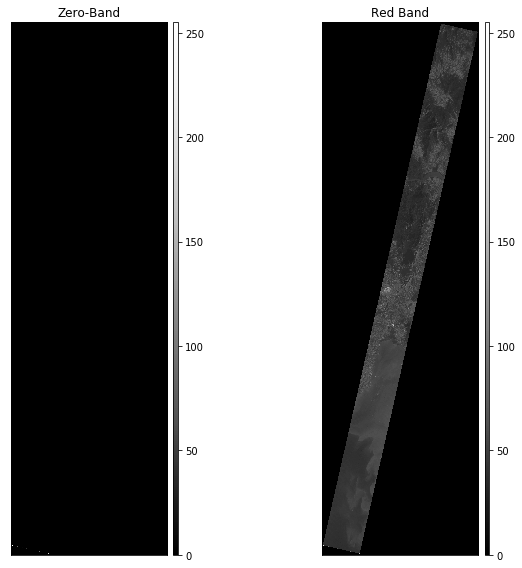

In [6]:
array, meta = es.stack(["/home/ec2-user/pixxel/EO1H1480472016328110PZ/EO1H1480472016328110PZ_B007_L1GST.TIF","/home/ec2-user/pixxel/EO1H1480472016328110PZ/EO1H1480472016328110PZ_B033_L1GST.TIF"])

titles=["Zero-Band","Red Band"]
ep.plot_bands(array, cols=2, title=titles, figsize=(10, 8))
plt.show()

Similarly, we can see the original image by stacking up all the 3 RGB bands

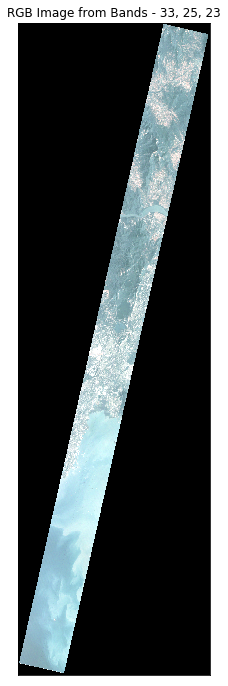

In [7]:
array, meta = es.stack(["/home/ec2-user/pixxel/EO1H1480472016328110PZ/EO1H1480472016328110PZ_B033_L1GST.TIF",
                        "/home/ec2-user/pixxel/EO1H1480472016328110PZ/EO1H1480472016328110PZ_B025_L1GST.TIF",
                       "/home/ec2-user/pixxel/EO1H1480472016328110PZ/EO1H1480472016328110PZ_B023_L1GST.TIF"])
fig, ax = plt.subplots(figsize=(12, 12))
ep.plot_rgb(
    array,
    ax=ax,
    stretch=True,
    str_clip=0.5,
    title="RGB Image from Bands - 33, 25, 23",
)
plt.show()

In [8]:
# Stacking up all the bands of the image

files=[]
for file in glob.glob("/home/ec2-user/pixxel/EO1H1480472016328110PZ/*.TIF"):
    files.append(file)
    
files.sort()
array, meta = es.stack(files, out_path='raster2.tiff')

Another visual showing shadows/highlights of elevated regions using Red and Near Infrared Bands

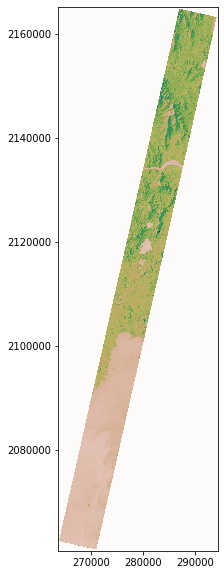

In [43]:
plt.figure(figsize=(12,10))
src = rasterio.open("/home/ec2-user/raster2.tiff")
show((src,45,33), cmap='gist_earth_r')

Now that we know how to import data and visualize our bands, we're still playing with visible spectrum band. Let's move to the invisible spectrum ie higher wavelength and see what we observe

#### Plotting Vegetation Range Using Red and Near Infra Red Bands

Intensly greener areas can be assumed as intense vegetation areas

This is calculated using **Normalized Difference Vegetation Index (NDVI)** which takes into accound the **Red and NIR** bands. In our case, these would be around band number 33 for red and band 55 for NIR

Formula For NDVI Index = *(nir - red) / (nir + red)*

Text(0.5, 1.0, 'NDVI')

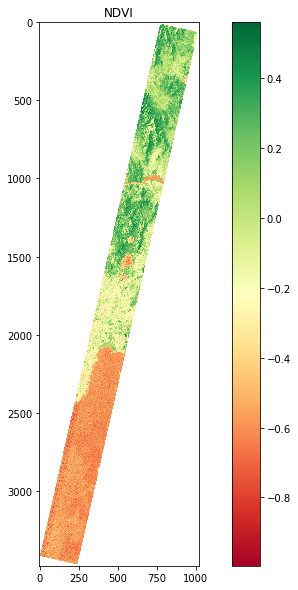

In [10]:
# Convert to numpy arrays
nir = src.read(55)
red = src.read(33)

# Normalize band
nir_norm = normalize(nir)
red_norm = normalize(red)

plt.figure(figsize=(12,10))
ndvi = calc_ndvi(nir_norm, red_norm)
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar()

plt.title('NDVI')

Similarly, let's see the vegetation index for our other tile: **EO1H1430452010208110Kt**

In [11]:
# Stacking up all the bands of the image

files=[]
for file in glob.glob("/home/ec2-user/pixxel/EO1H1430452010208110Kt/*.TIF"):
    files.append(file)
    
files.sort()
array, meta = es.stack(files, nodata=-9999, out_path='raster1.tiff')

Text(0.5, 1.0, 'NDVI')

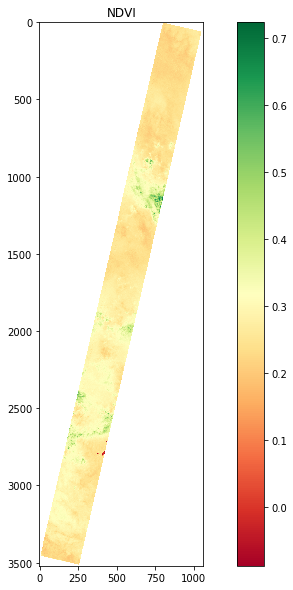

In [12]:
src = rasterio.open("/home/ec2-user/raster1.tiff")
# Convert to numpy arrays
nir = src.read(55)
red = src.read(33)

# Normalize band
nir_norm = normalize(nir)
red_norm = normalize(red)

plt.figure(figsize=(12,10))
ndvi = calc_ndvi(nir_norm, red_norm)
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar()

plt.title('NDVI')

This image has almost nil vegetation! Let's verify this by visualizing the original RGB Image

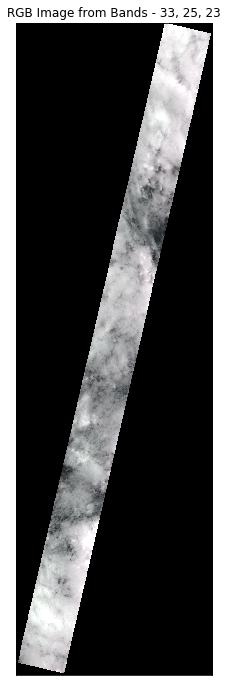

In [13]:
array, meta = es.stack(["/home/ec2-user/pixxel/EO1H1430452010208110Kt/EO1H1430452010208110Kt_B033_L1GST.TIF",
                        "/home/ec2-user/pixxel/EO1H1430452010208110Kt/EO1H1430452010208110Kt_B025_L1GST.TIF",
                       "/home/ec2-user/pixxel/EO1H1430452010208110Kt/EO1H1430452010208110Kt_B023_L1GST.TIF"])

fig, ax = plt.subplots(figsize=(12, 12))
ep.plot_rgb(
    array,
    ax=ax,
    stretch=True,
    str_clip=0.5,
    title="RGB Image from Bands - 33, 25, 23",
)
plt.show()

As we can observer, the real image shows signs of **clouds** but let's verify this.

For this example, we'll work on **Band 9** as it is a *Coastal Band* which is commmonly used for cloud detection. Following this, we'll compare the two images for cloud coverage over the area

In [14]:
def cloudDetect(file, clusters):
    landsat_pre_cl_path = file

    with rasterio.open(landsat_pre_cl_path) as landsat_pre_cl:
        landsat_qa = landsat_pre_cl.read(9)
        landsat_ext = plotting_extent(landsat_pre_cl)

    cmap = plt.cm.get_cmap('tab20b', clusters)
    # Get a list of unique values in the qa layer
    vals = np.unique(landsat_qa).tolist()
    bins = [0] + vals
    # Normalize the colormap 
    bounds = [((a + b) / 2) for a, b in zip(bins[:-1], bins[1::1])] + \
        [(bins[-1] - bins[-2]) + bins[-1]]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    fig, ax = plt.subplots(figsize=(12, 8))

    im = ax.imshow(landsat_qa,
                   cmap=cmap,
                   norm=norm)

    ep.draw_legend(im,
                   classes=vals[:clusters],
                   cmap=cmap, titles=vals[:clusters])

    ax.set_title("Quality Assessment Layer")
    ax.set_axis_off()
    plt.show()

Cloud coverage in **EO1H1430452010208110Kt** vs **EO1H1480472016328110PZ**.

#### Higher pixel intensity depicting greater presence of clouds

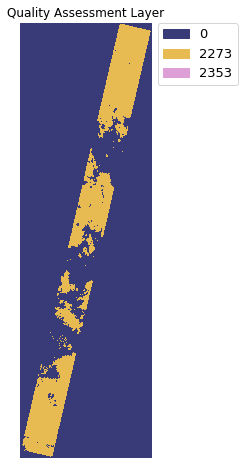

In [15]:
cloudDetect('raster1.tiff',3)

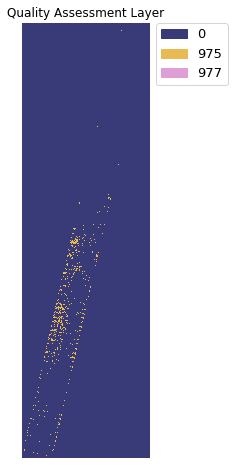

In [16]:
cloudDetect('raster2.tiff',3)

### WAVELET ANALYSIS

WA is another concept in observing the most prominent edges/boundaries in an image. Majorly, we have 3 components of interest, Horizontal, Vertical and Diagonal Details.

Each of these metrics would highlight the edges in the direction of their names. Horizontal would show all horizontal edges and so on. In a nuthsell, an *M x M* image is broken down into **M/2 x M/2** dimensions, basically downsampling the image.

An illustration of how image is broken into 4 coefficients and how different parts of image are highlighted in the 4 areas
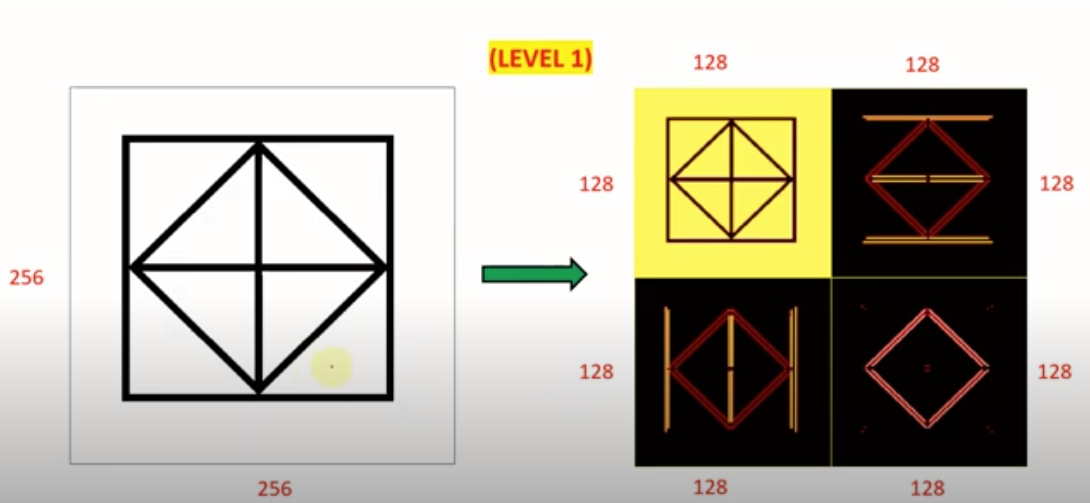

Some of its applications are in:

- Image Compression: Since we can also do inverse transform, ie generate the original image from the 4 coefficients. It is easier to store the residual parts of the image

- Noise Detection

There is one more component, Approximation Coefficient which generally outlines the image's low frequency areas. 
Here's how we can do **Level-1 Wavelet Analysis**

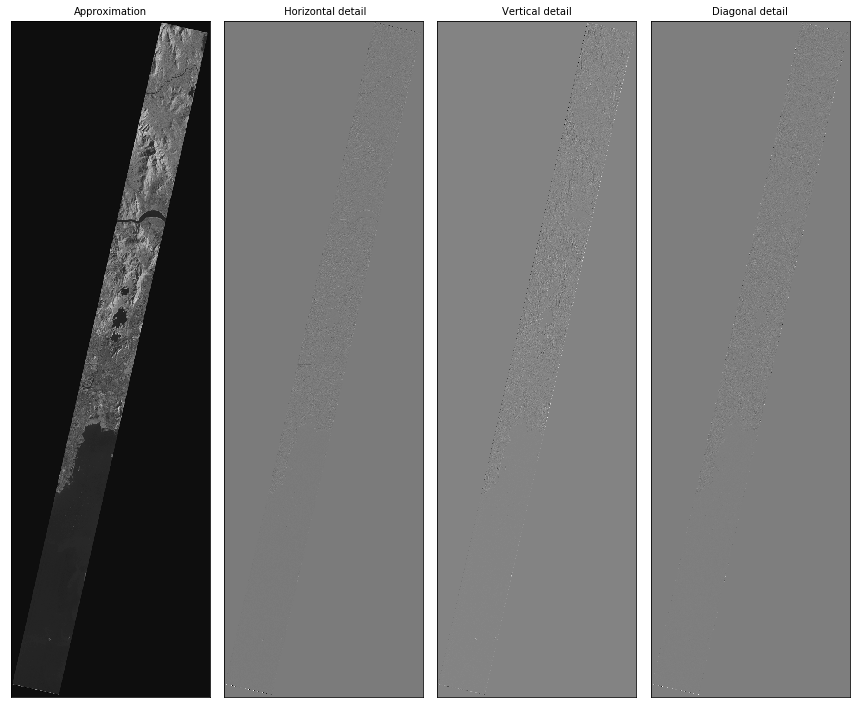

<Figure size 864x720 with 0 Axes>

In [45]:
original = tiff.imread('/home/ec2-user/pixxel/EO1H1480472016328110PZ/EO1H1480472016328110PZ_B050_L1GST.TIF')

titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']

coeffs2 = pywt.dwt2(original, 'bior1.3')

# Extract 4 coeff
LL, (LH, HL, HH) = coeffs2

fig = plt.figure(figsize=(12, 10))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.figure(figsize=(12,10))
plt.show()

## Part II: Pre-Processing & Clustering of Images

This brings us to the end of data exploring and visualization.

In this section of the assignment we'll dig deeper into different machine learning techniques using which we can learn more about these images in an unsupervised manner. 

**Approach:**

- Data Cleaning
- Dimensionality Reduction
- Clustering (Band/Pixel Level)

We'll start by performing cleaning of our image data. As an extension to our pre-processing step we'll also use techniques like **Principal Component Analysis** to reduce noise and perform analysis on only the most valuable of data points. 

Finally, we'll use **K-Means** algorithms to perform clustering at pixel and band levels.

- Band-Level: This will give us the most similar bands and their power of reflectance. We can stack all similar bands and visulaize them
- Pixel-Level: This is where we can segment different areas of our image into land/water etc. 

### Data Cleaning

While the hyperion gives us high-resolution images, we do need to know that every data comes with its own version of noise. In hyperspectral images, **Bad/Zero Bands** are a set of bands that do not carry any valuable data points for our use-case.

These are mostly pre-defined, although can also be removed by detecting *Signal Noise Ratio (SNR)* for each band. However, for EO1, zero-bands are **bands from 1 to 7, bands from 58 to 76 and bands from 225 to 242**

Other techniques like **Atmospheric Correction** will not be possible on images directly

In [18]:
# Stacking up all the bands of the image, deleting the specified indexes (bad bands) from final list

files=[]
for file in glob.glob("/home/ec2-user/pixxel/EO1H1480472016328110PZ/*.TIF"):
    files.append(file)

files.sort()
array = np.array(files)

array = np.delete(array,tuple(x for x in range(8)))
array = np.delete(array,tuple(x for x in range(57,76)))
array = np.delete(array,tuple(x for x in range(224,242)))

arrayBands, meta = es.stack(list(array), nodata=-9999, out_path='arrayBands.tiff')

In [19]:
print("Raster bands shape after removal: bands x width x height", arrayBands.shape)

Raster bands shape after removal: bands x width x height (215, 3481, 1021)


### Dimensionality Reduction

The objective here is to trim down the data of our image to fewer components/dimension such that we can get maximum variation from them. **PCA or Principal Component Analysis** that allows us to compress our data and return a set of eigenvectors or principal components with decreasing amount of variance.

In our case this would mean reducing the 242 Bands into fewer components while retaining maximum information. Hence, PCA would help us perform **Feature Elimination**, *removing not so valuable bands* and **Feature Extraction**, *creating new independent variables that represent our original band data*, but we select only some of these independent variable at the end.

This works because we make an assumption that more variability in a particular direction correlates with explaining the behavior of the dependent variable. Lots of variability usually indicates signal, whereas little variability usually indicates noise. Although PCA is sensitive to data scaling, hence we'd need to normalize it.

Also, our new image has only **215 Bands** now

In [20]:
#Normalize Bands

for i in range(arrayBands.shape[0]):
    arrayBands[i] = normalize(arrayBands[i])

Let's try to reduce our 215 Bands into 50, meaning extract 50 new components using PCA that have **almost** the same information as the 215

In [21]:
#PCA Setup

pca = PCA(n_components = 50)
arrs = arrayBands.reshape((arrayBands.shape[0],arrayBands.shape[1]*arrayBands.shape[2]))
pcaBands = pca.fit_transform(arrs)

Our new array, having 50 dimensions, each dimension containing a single value for each of the 215 bands, hence, 215 x 50

In [22]:
pcaBands.shape

(215, 50)

Here is the amount of variation/information represented by each of these components, If you add up first 11 components, that'd give us **95%** of the information presented in orginal 215 bands.

In [23]:
np.round(pca.explained_variance_ratio_,2)

array([0.38, 0.2 , 0.13, 0.08, 0.05, 0.03, 0.03, 0.02, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

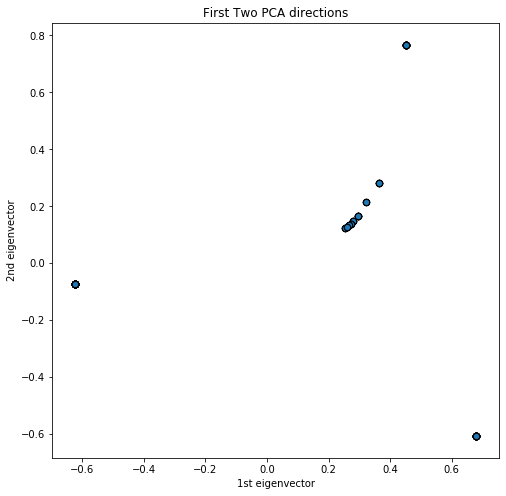

In [24]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.scatter(pcaBands[:, 0], pcaBands[:, 1], cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First Two PCA directions")
ax.set_xlabel("1st eigenvector")
ax.set_ylabel("2nd eigenvector")

plt.show()

In [25]:
#Filtering out only first 11 components for further clustering

pcaBands=pd.DataFrame(pcaBands)
pcaBands=pcaBands.iloc[:,:11]

### Clustering: K-Means

A commonly used algorithm for clustering applications. To summarize, k-means works by starting of by **K** random points while calculating the distance of each data point to the K-points. The closest points are grouped together at every iteration and the centroid ie K, eventually moves to the center of the cluster by calculating the mean of the cluster on every iteration.

The only challenge being that **K** has to be an input to the aglorithm. There is no global K, hence, we'd need to calculate the optimal K for our dataset.

#### WCSS: Within Cluster Sum of Squares

This is one such technique that can help us in deciding a good K for our data. The best scenario would be where each point is treated as a cluster of its own, hence, **WCSS=0**

Although, that is not insightfull, so we'd need to find the optimal number where our WCSS first hits 0.

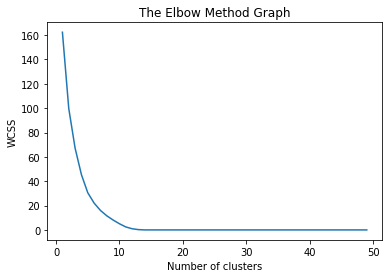

In [26]:
wcss=[]

for i in range(1,50): 
    kmeans = KMeans(n_clusters=i, init ='k-means++', n_init=10 )
    kmeans.fit(pcaBands)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,50),wcss)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Nearing 10 or 11 is where our WCSS approaches 0

In [27]:
#BAND LEVEL CLUSTERING: Creating 10 Clusters

kmeans = KMeans(init='k-means++', n_clusters=10, n_init=10)
pcaPreditBands=kmeans.fit_predict(pcaBands)

Each band is now labelled to either of the 10 clusters

In [28]:
pcaPreditBands

array([6, 6, 9, 6, 1, 6, 1, 6, 9, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 9, 3, 3, 3, 9, 3, 3, 3, 3, 9, 6, 6, 3, 3, 3, 1,
       1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 7, 7, 8, 1, 1, 1, 8, 8, 8,
       8, 1, 2, 5, 5, 7, 7, 5, 5, 5, 2, 2, 2, 2, 2, 2, 2, 5, 5, 2, 2, 2,
       5, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 5, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

A representation of reflectance of each cluster accross all bands. Cluster 0 and 1 compared in this case

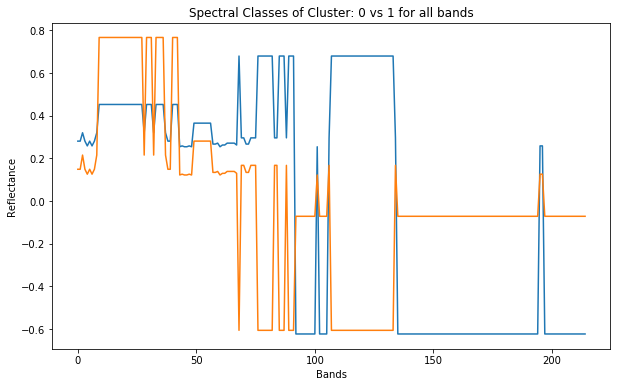

In [29]:
def getBandReflectance(clusterNumber1, clusterNumber2):
    pylab.figure(figsize=(10,6))
    
    pylab.plot(pcaBands[clusterNumber1])
    pylab.plot(pcaBands[clusterNumber2])
    
    pylab.show
    pylab.title('Spectral Classes of Cluster: '+str(clusterNumber1)+' vs '+str(clusterNumber2)+' for all bands')
    pylab.xlabel('Bands')
    pylab.ylabel('Reflectance')
    
getBandReflectance(0,1)

In [30]:
bands=tuple(x+1 for x in tuple(np.where(pcaPreditBands==9)[0]))
str(bands)

'(3, 9, 29, 33, 38)'

Some representations of the image when similar bands are staked together

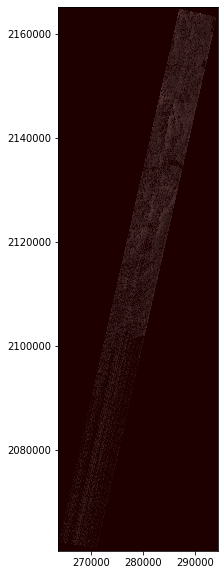

In [31]:
infile = 'arrayBands.tiff'
im = rasterio.open(infile)

plt.figure(figsize=(12,10))
show((im,93, 94, 95, 96, 97, 98, 99, 100, 101, 103, 104, 105, 106, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215), cmap='pink')

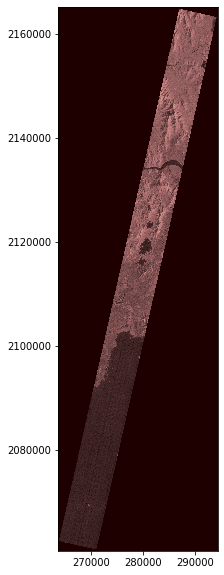

In [32]:
infile = 'arrayBands.tiff'
im = rasterio.open(infile)

plt.figure(figsize=(12,10))
show((im,69, 77, 78, 79, 80, 81, 82, 83, 86, 87, 88, 90, 91, 92, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134), cmap='pink')

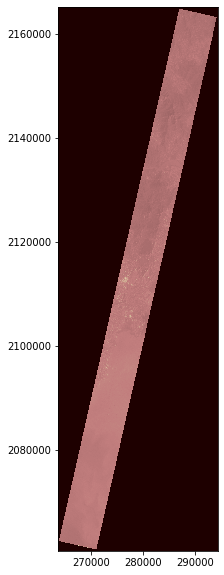

In [33]:
infile = 'arrayBands.tiff'
im = rasterio.open(infile)

plt.figure(figsize=(12,10))
show((im,10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 34, 35, 36, 37, 41, 42, 43), cmap='pink')

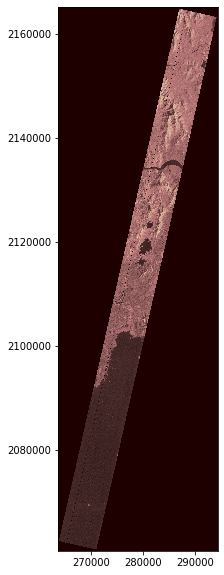

In [34]:
infile = 'arrayBands.tiff'
im = rasterio.open(infile)

plt.figure(figsize=(12,10))
show((im,60, 64, 65, 66, 67), cmap='pink')

#### PIXEL-LEVEL CLUSTERING

Finally, we'd be applying the same concepts on pixel level, irrespective of the bands. We'll try this with **K-Means** algorithm

We'll continue working on our 215-Band image

Since we can work only on a particular band, here are a few bands we can try **1, 26, 43**. Band 1 is actually band 9 since we've removed the first 7 bands. Band 9 or 1, is the costal band, 26 -> red and 43 a NIR band.

An optimal number of clusters were observed as 3,4 and 5 from WCSS method

In [35]:
def createCluster(bandNumber, clusters):
    
    dataset=rasterio.open('arrayBands.tiff').read()
    print(dataset.shape)
    
    if bandNumber <= dataset.shape[0]:
        df = pd.DataFrame(dataset[bandNumber])
        print("Orginal Shape: ", df.shape)
        
        #Remove dimension if all pixels are 0
        df = df.loc[:, (df != 0).any(axis=0)]
        print("New Shape After Pixel Removal: ", df.shape)
        
        X = df.values.reshape((-1, 1))
        
        k_means = KMeans(n_clusters=clusters, init ='k-means++', n_init=10)
        _ = k_means.fit(X)
        
        X_clustered = k_means.labels_
        X_clustered = X_clustered.reshape(df.shape)
        
        plt.figure(figsize=(16,16))
        plt.imshow(X_clustered, cmap="viridis")
        plt.show()

An illustration of 5 cluster on NIR Band ie 43, separating water, land and elevated regions in the image when compared to the original RGB image on the right

In [36]:
#Original RGB

array, meta = es.stack(["/home/ec2-user/pixxel/EO1H1480472016328110PZ/EO1H1480472016328110PZ_B033_L1GST.TIF",
                        "/home/ec2-user/pixxel/EO1H1480472016328110PZ/EO1H1480472016328110PZ_B025_L1GST.TIF",
                       "/home/ec2-user/pixxel/EO1H1480472016328110PZ/EO1H1480472016328110PZ_B023_L1GST.TIF"])

(215, 3481, 1021)
Orginal Shape:  (3481, 1021)
New Shape After Pixel Removal:  (3481, 1008)


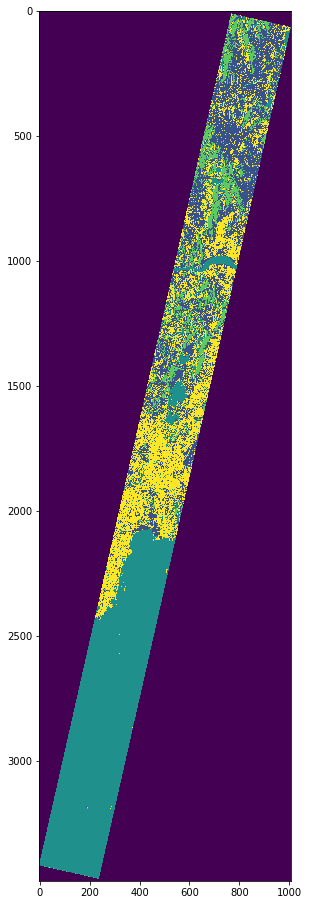

In [37]:
createCluster(43, 5)

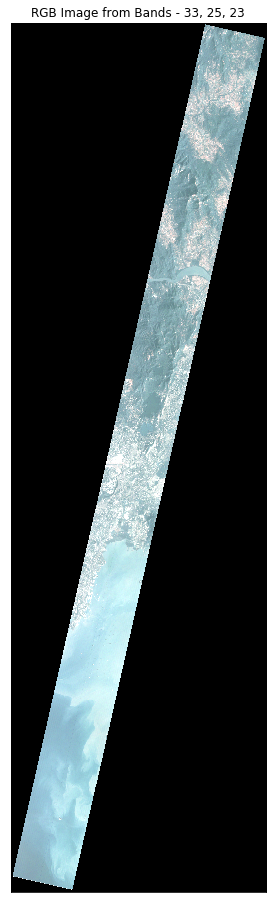

In [38]:
fig, ax = plt.subplots(figsize=(16, 16))
ep.plot_rgb(array, ax=ax, stretch=True, str_clip=0.5, title="RGB Image from Bands - 33, 25, 23")
plt.show()

END